In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from dpm.visualize import plot_hist, plot_model, plot_models, plot_hists

# Approximating Pi

In [2]:
def plot_samples(samples, distances, n_plot=10000):
    idx = torch.randperm(min(n_plot, samples.size(0)))
    p_samples, distances = samples[idx], distances[idx]
    accepted = p_samples[distances < 1.].numpy()
    rejected = p_samples[distances >= 1.].numpy()
    plt.figure(figsize=(7, 7))
    plt.scatter(accepted[:, 0], accepted[:, 1], s=4); plt.scatter(rejected[:, 0], rejected[:, 1], s=4)
    plt.xlim(0., 1.); plt.ylim(0., 1.)
    

def sample(batch_size):
    return torch.rand((batch_size, 2))

def distance(samples):
    return samples.pow(2).sum(dim=1).sqrt()

def monte_carlo(batch_size, plot=False):
    samples = sample(batch_size)
    distances = distance(samples)
    if plot: plot_samples(samples, distances)
    ratio = 4 * (distances < 1.).float().sum() / batch_size
    return ratio

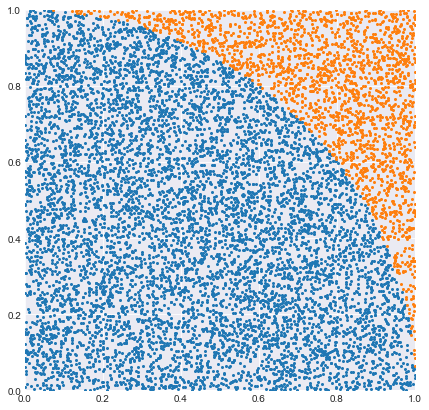

In [57]:
monte_carlo(100000, plot=True)
plt.savefig('../../Presentations/sampling/assets/approx_pi_circle.png', bbox_inches='tight', dpi=300)
plt.show()

In [29]:
def plot_monte_carlo_err(batch_size):
    samples = sample(batch_size)
    distances = distance(samples)
    print(distances.shape, samples.shape)
    ratio = 4 * torch.cumsum((distances < 1.).float(), 0) / torch.cumsum(torch.ones(batch_size).float(), 0)
    return ratio

torch.Size([100000]) torch.Size([100000, 2])


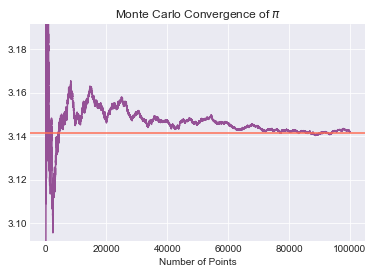

In [56]:
plt.plot(plot_monte_carlo_err(100000).numpy(), color="#955196")
plt.ylim(np.pi-0.05, np.pi+.05)
plt.axhline(np.pi, color='#ff6e54')
plt.title(r"Monte Carlo Convergence of $\pi$")
plt.xlabel('Number of Points')
plt.savefig('../../Presentations/sampling/assets/approx_pi_error.png', bbox_inches='tight', dpi=300)
plt.show()

# LCG

In [6]:
from dpm.monte_carlo import rand, lcg

g = lcg()
for i in range(10):
    print(next(g))

1680588
675057779
713713492
1295248114
689724154
1311030043
827663638
1788785909
852207936
356854227


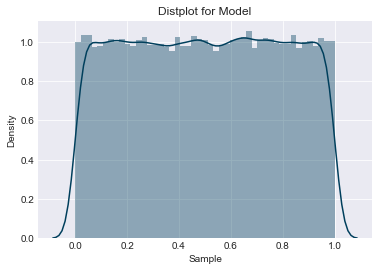

In [7]:
plot_hist(rand(100000, generator=g))

# Box Muller

In [8]:
from dpm.monte_carlo import box_muller
from dpm.visualize import plot_hist

In [9]:
# Works!
Z1, Z2 = box_muller()
print(Z1.shape, Z2.shape)
print(Z1.mean(), Z1.var())
print(Z2.mean(), Z2.var())

torch.Size([10000, 1]) torch.Size([10000, 1])
tensor(0.0093) tensor(1.0070)
tensor(0.0005) tensor(0.9919)


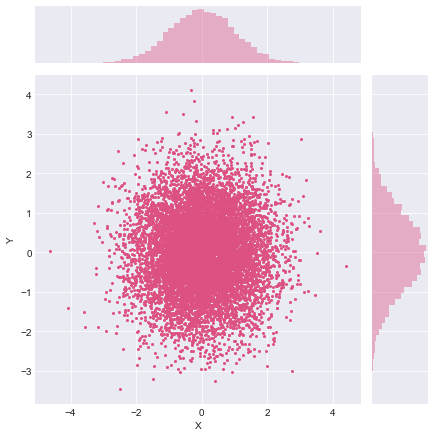

In [10]:
plot_hist(torch.cat((Z1, Z2), dim=1))
plt.show()

# Marsaglia - Bray

In [11]:
from dpm.monte_carlo import marsaglia_bray
from dpm.visualize import plot_hist

In [12]:
# Works!
Z1, Z2 = marsaglia_bray()
print(Z1.shape, Z2.shape)
print(Z1.mean(), Z1.var())
print(Z2.mean(), Z2.var())

torch.Size([7826, 1]) torch.Size([7826, 1])
tensor(-0.0080) tensor(1.0109)
tensor(-0.0035) tensor(1.0098)


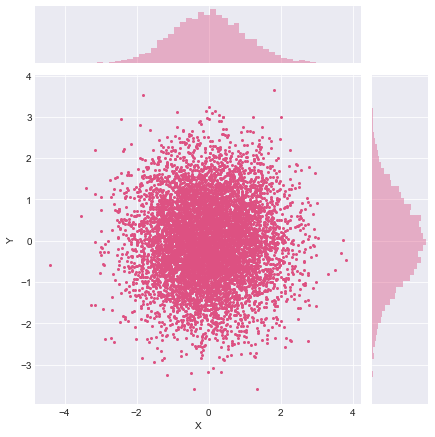

In [13]:
plot_hist(torch.cat((Z1, Z2), dim=1))
plt.show()

# Normal ICDF

In [14]:
from dpm.monte_carlo import inverse_sampling
from functools import partial

def normal_icdf(p, mu, sigma):
    return mu + sigma * np.sqrt(2.) * torch.erfinv(2 * p - 1)

n_icdf = partial(normal_icdf, mu=0., sigma=1.)

torch.Size([10000, 1])
tensor([0.0077]) tensor([0.9966])


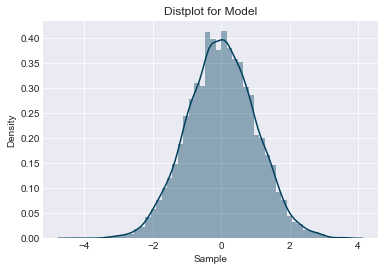

In [15]:
samples = inverse_sampling(n_icdf)
print(samples.shape)
print(samples.mean(dim=0), samples.var(dim=0))
plot_hist(samples)

torch.Size([10000, 2])
tensor([-0.0053, -0.0029]) tensor([1.0031, 1.0112])


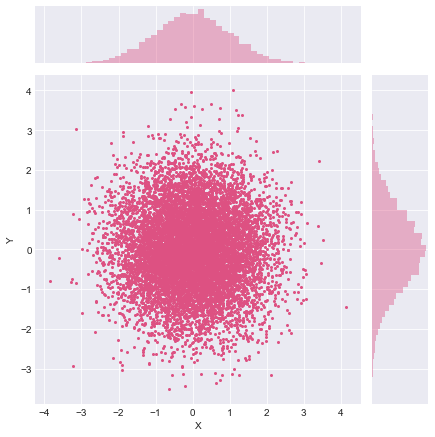

In [16]:
samples = inverse_sampling(n_icdf, n_dims=2)
print(samples.shape)
print(samples.mean(dim=0), samples.var(dim=0))
plot_hist(samples)

# Rejection Sampling

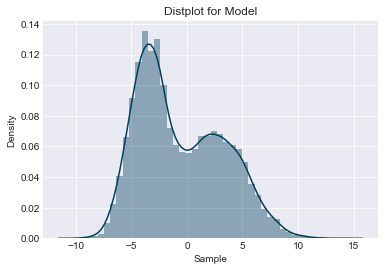

In [17]:
from dpm.distributions import Normal
from dpm.mixture_models import MixtureModel

p_model = MixtureModel([Normal(-3.7, 2.3, learnable=False), 
                        Normal(2.6, 7.5, learnable=False)],
                       [0.5, 0.5])
q_model = Normal(0., 100., learnable=False)
plot_model(p_model)

torch.Size([10027, 1])


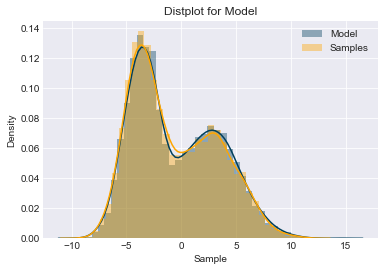

In [18]:
from dpm.monte_carlo import rejection_sampling

samples = rejection_sampling(p_model, q_model, 10, batch_size=100000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

# MCMC

torch.Size([900, 1])


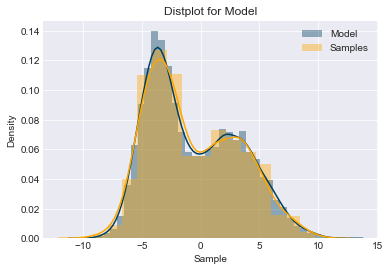

In [24]:
from dpm.monte_carlo import metropolis

samples = metropolis(p_model, keep_every=10, burn_in=1000, variance=3 * torch.eye(1), epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

torch.Size([900, 1])


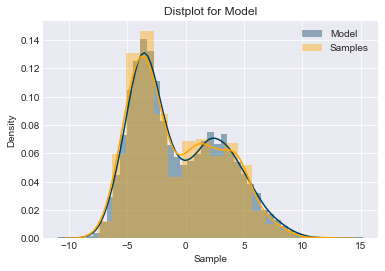

In [25]:
from dpm.monte_carlo import metropolis_hastings
from functools import partial

q_model = partial(Normal, scale=3 * torch.eye(1), learnable=False)

samples = metropolis_hastings(p_model, q_model, keep_every=10, burn_in=1000, epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

torch.Size([900, 1])


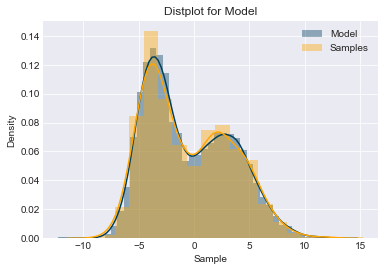

In [27]:
from dpm.monte_carlo import metropolis_langevin

samples = metropolis_langevin(p_model, keep_every=10, burn_in=1000, epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])